### Toymodel as an initial test
This section is mostly the initial feature engineering. We also create a simple toymodel just to see how the decision tree performs and a correlation matrix to find possible redundant features. 

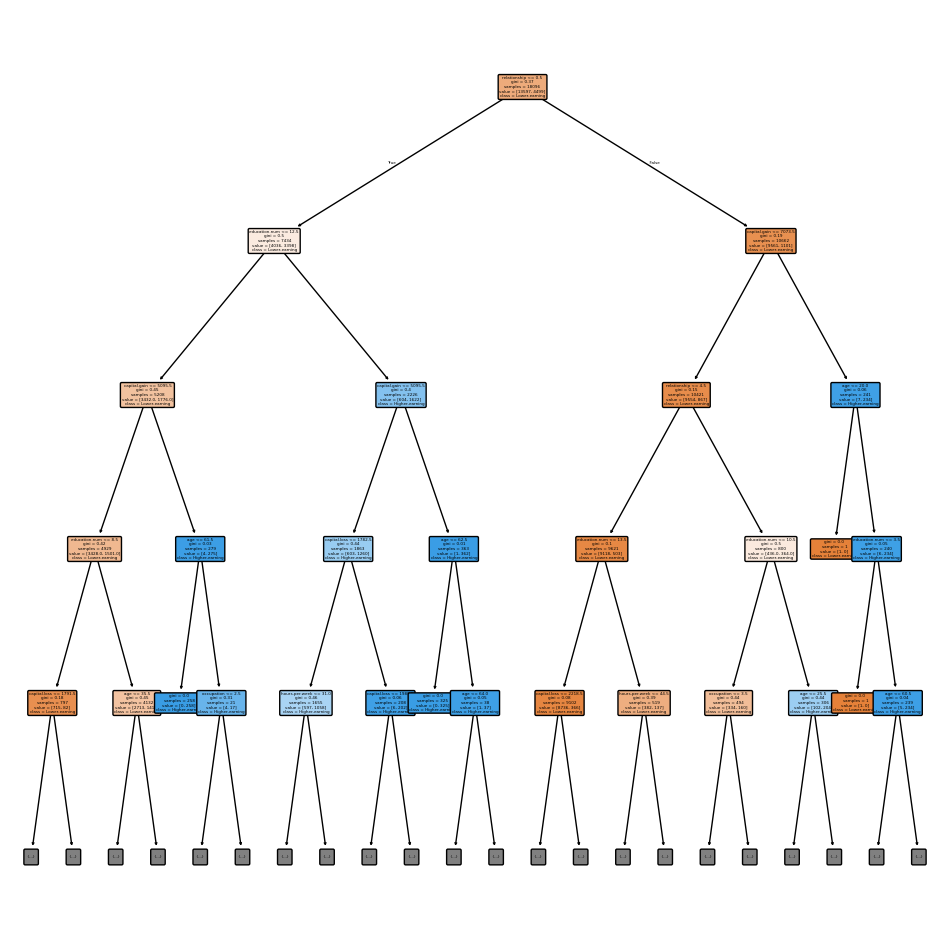

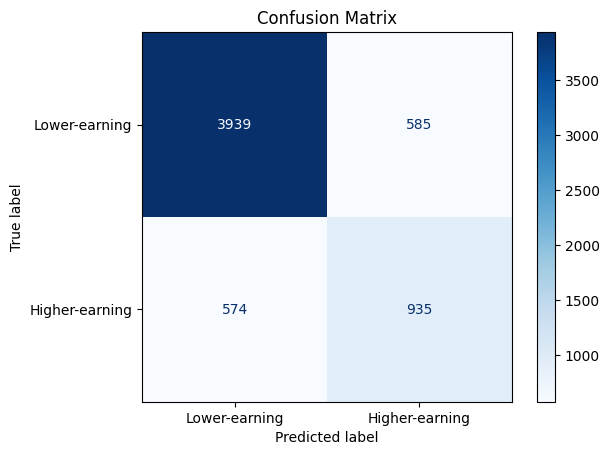

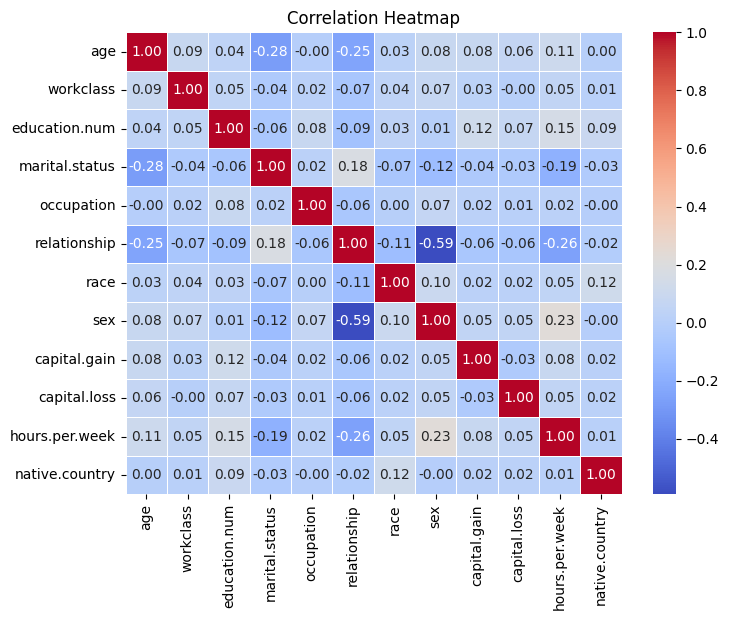

Classification Report:
                precision    recall  f1-score   support

 Lower-earning       0.87      0.87      0.87      4524
Higher-earning       0.62      0.62      0.62      1509

      accuracy                           0.81      6033
     macro avg       0.74      0.75      0.74      6033
  weighted avg       0.81      0.81      0.81      6033



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Load dataset
df = pd.read_csv('./Datasets/adult.csv', comment = '#')

# First, create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()
df_encoded.drop(['fnlwgt', 'education'], axis=1, inplace=True)

# drop all rows that contain '?'
df_encoded = df_encoded[(df_encoded != '?').all(axis=1)]

# Apply label encoding to categorical columns
categorical_columns = ['workclass', 'marital.status', 'occupation', 
                      'relationship', 'race', 'sex', 'native.country', 'income']

for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Separate features and target
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# Build pipeline
model = Pipeline([
    ('full_dt_classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Visualize the decision tree
plt.figure(figsize=(12, 12))
plot_tree(
    model.named_steps['full_dt_classifier'],
    feature_names=X.columns,
    class_names=["Lower-earning", "Higher-earning"],
    filled=True,
    rounded=True,
    max_depth=4,       
    fontsize=3,
    precision=2        
)

plt.savefig('decision_tree.pdf', format='pdf', dpi=300)
plt.show()

CM = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Lower-earning", "Higher-earning"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()  

# Create a correlation matrix
matrix = X_train.corr()
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Lower-earning", "Higher-earning"]))

### Classifier comparison
This is taken from the ensemble lab with some small adjustments. A lot of models are excluded, but they are easy to implement into the class. We can also tune more parameters for each model, but of course that would also increase the execution time.

As you can see we have included xgboost as we thought it was an interesting model to try on this dataset. However, we couldn't include it in the report as it would become too long.

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier        # Requires installation of the package ; Not a native function in sklearn

class ClassifierComparisonOpt:
    def __init__(self, X, y, test_size=0.25, use_bootstrap=True, random_state=42, cv_folds=10):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)

        # Scaling not necessary for decision trees
        self.X_train = X_train
        self.X_test = X_test

        self.y_train       = y_train
        self.y_test        = y_test
        self.use_bootstrap = use_bootstrap
        self.cv_folds      = cv_folds
        self.models        = {}
        self.results       = {}
        self.results_df    = None
        self.feature_names = list(X.columns)

    def get_models_with_params(self):
        return {
            'Decision Tree': (DecisionTreeClassifier(random_state=42), {
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [2, 4, 6]
            }),
            'Random Forest': (RandomForestClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [2, 4, 6]
            }),
            'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            })
        }

    def fit_models(self, models_with_params=None):
        # Set self.get_models_with_params() as a default parameter distribution
        if models_with_params == None:
            models_with_params = self.get_models_with_params()

        results_list = []
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)

        for name, (model, param_grid) in models_with_params.items():
            print(f"Tuning {name} ...")
            
            grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
            
            start_train = time.time()
            grid_search.fit(self.X_train, self.y_train)
            end_train = time.time()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            end_pred = time.time()

            self.models[name] = {
                'model': best_model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Best Params': grid_search.best_params_,
                'Training Time (s)': (end_train - start_train),
                'Prediction Time (s)': (end_pred - end_train),
                'Total Time (s)': (end_pred - start_train)
            }

            results_list.append(metrics)

        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    # Show feature importance for models that support it          
    def show_feature_importance(self):
        importance = {}
        features = self.feature_names

        for name, result in self.models.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance[name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                coef = model.coef_
                if coef.ndim == 1:
                    importance[name] = np.abs(coef)
                else:
                    importance[name] = np.mean(np.abs(coef), axis=0)
            else:
                print(f"Feature importance not available for model {name}")

        for name, imp in importance.items():
            sorted_idx = np.argsort(imp)[::-1]
            sorted_features = [features[i] for i in sorted_idx]
            plt.figure()
            plt.bar(range(len(imp)), imp[sorted_idx], align='center')
            plt.xticks(range(len(imp)), sorted_features, rotation=70)
            plt.title(f"Feature importance for {name}")
            plt.xlabel("Feature index")
            plt.ylabel("Importance score")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()


### Compare models with coarse hyperparameter tuning

In [25]:
# optimized classifiers and find their hyperparameters
clf_opt = ClassifierComparisonOpt(X_train_val, y_train_val)
clf_opt.fit_models()
clf_opt.print_summary()

Tuning Decision Tree ...


Tuning Random Forest ...
Tuning XGBoost ...

------ Results Sorted by Accuracy ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
      XGBoost  0.868059   0.863590 0.868059  0.863957     {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}          54.522120             0.022445       54.544564
Random Forest  0.858942   0.853479 0.858942  0.853443 {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}         152.761754             0.094559      152.856313
Decision Tree  0.848334   0.844900 0.848334  0.846228                       {'max_depth': 10, 'min_samples_split': 5}           7.268746             0.003260        7.272006

------ Results Sorted by Total Time ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)


### Finetune and compare again
After tuning with a coarse grid we can use the result to select a finer grid and find better hyperparameters. This will only slightly improve the models, you will generally get diminishing returns the finer you tune.

Tuning Decision Tree ...
Tuning Random Forest ...
Tuning XGBoost ...

------ Results Sorted by Accuracy ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
      XGBoost  0.868556   0.864049 0.868556  0.864181      {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 75}          27.877137             0.011091       27.888228
Random Forest  0.858942   0.853479 0.858942  0.853443 {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}         136.946045             0.074518      137.020563
Decision Tree  0.849163   0.843062 0.849163  0.839388                        {'max_depth': 8, 'min_samples_split': 6}           2.567322             0.006399        2.573721

------ Results Sorted by Total Time ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction 

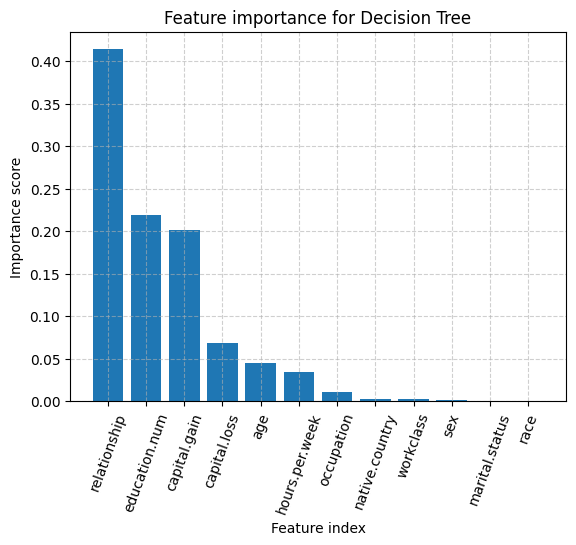

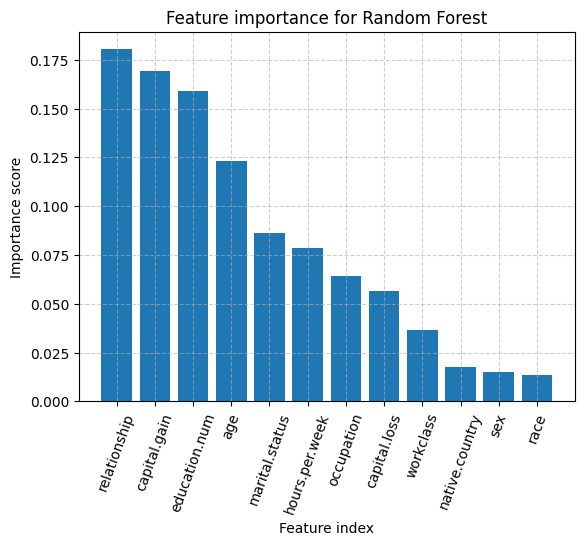

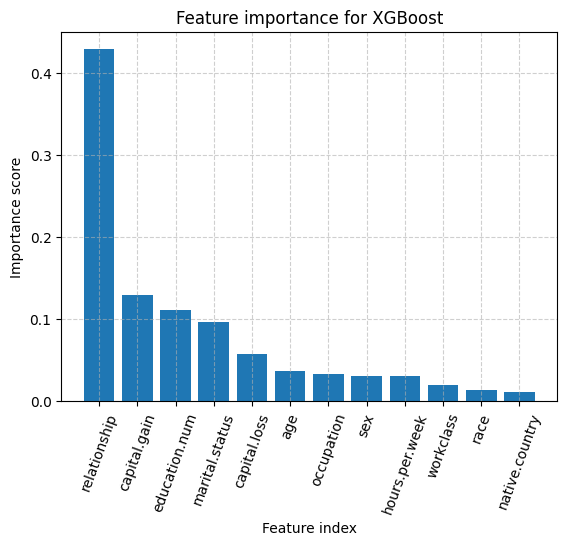

In [26]:
# Define the classifiers and their hyperparameters in a finer grid
def get_fine_grids(use_bootstrap=True):
    return {
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [8, 10, 12],
            'min_samples_split': [4, 5, 6],
        }),
        'Random Forest': (RandomForestClassifier(bootstrap=use_bootstrap, random_state=42, n_jobs=-1), {
            'n_estimators': [75, 100, 150], 
            'max_depth': [15, 20, 25],
            'min_samples_split': [8, 10, 12],
        }),
        'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1), {
                'n_estimators': [75, 100, 150],
                'learning_rate': [0.15, 0.2, 0.25],
                'max_depth': [4, 5, 6]
            })
    }

# optimized classifiers and find their hyperparameters
clf_opt = ClassifierComparisonOpt(X_train_val, y_train_val)
fine_grid = get_fine_grids()
clf_opt.fit_models(fine_grid)
clf_opt.print_summary()

# Show feature importance for each model
clf_opt.show_feature_importance()

### Remove redundant features (optional)
This section is only used to see how the removal of redundant features will affect the validation metrics. We have kept this section optional since we may want to use the same feature sets for all models in order to produce a fair comparison. Infact, for our final models we decided to not remove the redundant features as we aimed to compare the models and therefore wanted them to have the same feature sets. Nevertheless, for optimal performance of each model, removing redundant features is advantegous.

In [27]:
# Remove redundant features for decision tree
X_dt = X_train_val.drop(columns=['sex', 'native.country', 'marital.status', 'race', 'occupation', 'workclass'])

# Remove redundant features for XGBoost
X_xgb = X_train_val.drop(columns=['native.country', 'race'])

# Remove redundant features for Random Forest
X_rf = X_train_val.drop(columns=['native.country', 'sex', 'race'])

# Train decision tree without redundant features
cmp_dt = ClassifierComparisonOpt(X_dt, y_train_val)
cmp_dt.fit_models({'Decision Tree': fine_grid['Decision Tree']})

# Train XGBoost without redundant features
cmp_xgb = ClassifierComparisonOpt(X_xgb, y_train_val)
cmp_xgb.fit_models({'XGBoost': fine_grid['XGBoost']})

# Train Random Forest without redundant features
cmp_rf = ClassifierComparisonOpt(X_rf, y_train_val)
cmp_rf.fit_models({'Random Forest': fine_grid['Random Forest']})

# Print results
res = pd.concat([cmp_dt.results_df, cmp_rf.results_df, cmp_xgb.results_df])
print("\n------ Results Sorted by Accuracy ------")
print(res.sort_values(by='Accuracy', ascending=False).to_string(index=False))

Tuning Decision Tree ...
Tuning XGBoost ...
Tuning Random Forest ...

------ Results Sorted by Accuracy ------
        Model  Accuracy  Precision   Recall  F1 Score                                                    Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
      XGBoost  0.867893   0.863335 0.867893  0.863496   {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}          27.545653             0.011063       27.556716
Random Forest  0.859606   0.854161 0.859606  0.853520 {'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 150}         117.926460             0.047736      117.974195
Decision Tree  0.848666   0.843533 0.848666  0.837078                       {'max_depth': 8, 'min_samples_split': 4}           1.503573             0.004421        1.507995


### Final Models
After finding optimal hyperparameters, we can train the final models. As you can see we are not using pipeline here as we do not have to use scaling for our models. Importantly though, if we were to use models that benefits from scaling, that would be a very important step in both the hyperparameter tuning and in training the final models.

Classification Report for Decision Tree:
                precision    recall  f1-score   support

 Lower-earning       0.87      0.95      0.90      4533
Higher-earning       0.77      0.56      0.65      1500

      accuracy                           0.85      6033
     macro avg       0.82      0.75      0.78      6033
  weighted avg       0.84      0.85      0.84      6033



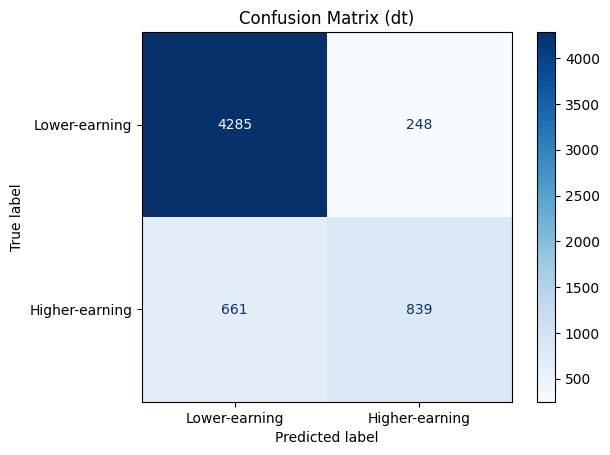

Classification Report for Random Forest:
                precision    recall  f1-score   support

 Lower-earning       0.89      0.94      0.91      4533
Higher-earning       0.77      0.63      0.70      1500

      accuracy                           0.86      6033
     macro avg       0.83      0.79      0.80      6033
  weighted avg       0.86      0.86      0.86      6033



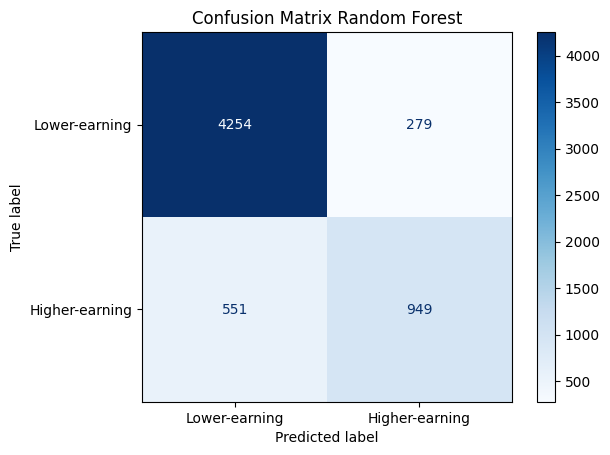

Classification Report For XGBoost:
                precision    recall  f1-score   support

 Lower-earning       0.89      0.94      0.91      4533
Higher-earning       0.77      0.66      0.71      1500

      accuracy                           0.87      6033
     macro avg       0.83      0.80      0.81      6033
  weighted avg       0.86      0.87      0.86      6033



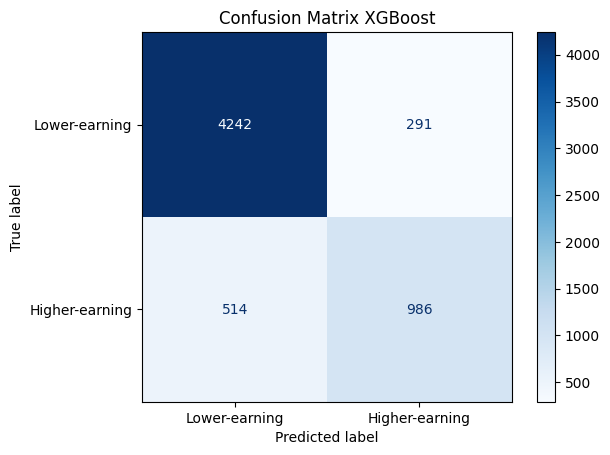

In [28]:
# --------------------------------------- Decision Tree ---------------------------------------
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=4, random_state=42)

# Train the model
dt.fit(X_train_val, y_train_val)
y_pred_dt = dt.predict(X_test)

# Classification Report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=["Lower-earning", "Higher-earning"]))

CM = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Lower-earning", "Higher-earning"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (dt)")
plt.savefig('./Report/CM_dt.png', format='png', dpi=300)
plt.show()  


# --------------------------------------- Random Forest ---------------------------------------
rf = RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=100, bootstrap=True, random_state=42)

# Train the model
rf.fit(X_train_val, y_train_val)
y_pred_rf = rf.predict(X_test)

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["Lower-earning", "Higher-earning"]))

CM = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Lower-earning", "Higher-earning"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Random Forest")
plt.savefig('./Report/CM_rf.png', format='png', dpi=300)
plt.show() 


# --------------------------------------- XGBoost ---------------------------------------
xgb = XGBClassifier(learning_rate=0.15, max_depth=5, n_estimators=100, random_state=42)

# Train the model
xgb.fit(X_train_val, y_train_val)
y_pred_xgb = xgb.predict(X_test)

# Classification Report
print("Classification Report For XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=["Lower-earning", "Higher-earning"]))

CM = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Lower-earning", "Higher-earning"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix XGBoost")
plt.savefig('./Report/CM_xgb.png', format='png', dpi=300)
plt.show() 